## 本节重点

1. 设置交易佣金、滑点
2. 订单order的各种状态
3. 输出交易日志
4. 交易trader的介绍
5. 向策略中传入参数

## 一、滑点
### 滑点是什么

滑点，是指在进行交易时，客户下达的指定交易价格与实际成交价格存在较大差别的一种现象。 

每个交易者都会碰到滑点，不管他们交易的是股票、外汇还是期货。 

假设客户在平台上看到的欧元对美元的报价是1.2000，而市场在这个价格上能接受的交易量是500万美金，如果客户下单量是600万美金，那怎么办呢？其中500万美金就会以1.3000成交，其余的100万美金则会以下一个价格成交，可能会是1.2001或是更高的价格。

###  滑点产生的原因

1. 市场报价断层

![盘口](images/盘口.png)

2. 网络原因

![交易延迟](images/延迟.png)

#### 1. **滑点管理**

为了让回测结果更真实，在交易前可以通过brokers设置滑点

滑点的类型有2种：
    1. **百分比滑点**
    2. **固定滑点**

不论哪种设置方式，都是起到相同的作用：买入时，在指定的价格的基础上提高实际买入价格；卖出时，在指定价格的基础上，降低实际卖出价格；买的“更贵”，卖的“更便宜”。

**如果同时设置了百分比滑点和固定滑点，前者的优先级高于后者，最终按百分比滑点的设置处理**

**百分比滑点**
假设设置了n%的滑点，如果指定的买入价为x，那实际成交时的买入价会提高至x*（1+n%）； 

同理，若指定的卖出价为x，那实际成交时的卖出价会降低至x*（1-n%），下面时将滑点设置为0.01%的例子 

> **cerebro.broker.set_slippage_perc(perc=0.0001)

**固定滑点**
假设设置了大小为n的固定滑点，如果指定的买入价为x，那实际成交时的买入价会提高至x+n

同理，若指定的卖出价为x，那实际成交时的卖出价会降低至x-n

> **cerebro.broker.set_slippage_fixed(fixed=0.001)

**有关滑点的其他设置**
除了用于设置滑点的slip_perc和slip_fixed参数外，broker还提供了其他参数用于处理价格出现滑点后的极端情况：
- **slip_open**: 是否对开盘价做滑点处理，该参数在BackBroker() 类中默认为False，在set_slippage_perc 和 set_slippage_fixed 方法中默认为True；
- **slip_match**: 是否将滑点处理后的新成交价与成交当天的价格区间low~high做匹配，如果为True，则根据新成交价重新匹配调整价格区间，确保订单能被执行；如果为False，则不会与价格区间做匹配，订单不会执行，但会在下一日执行一个空订单；默认取值为True；
- **slip_out: 如果新成交高于最高价或低于最高价，是否以超出的价格成交，如果为True，则允许以超出的价格成交；如果为False，实际成交价将被限制在价格区间内low ~ high；默认取值为False；
- **slip_limit: 是否对限价单执行滑点，如果为True，即使slip_match为Fasle,也会对价格做匹配，确保订单被执行；如果为Fasle，则不做价格匹配；默认取值为True。

下面是将滑点设置为固定0.35，对上述参数去不同的值，标的600466.SH在2019-01-17的成交情况做对比：

2019-01-17， Close, 32.0779
2019-01-17, Open, 32.6331

#### 情况1：
set_slippage_fixed(fixed=0.35,
                   slip_open=False,
                   slip_match=True,
                   slip_out=False)
                   
#### 由于 slip_open=False, 不会对开盘价做滑点处理，所以仍然以原始开盘价 32.63307367 成交
......
date 2019-01-16 open 33.00320305 low 32.57138544 high 33.00320305
2019-01-17, BUY EXECUTED, ref:249，Price: 32.6331, Cost: 3263.3074, Comm 0.9790, Size: 100.00, Stock: 600466.SH
2019-01-17, 当前持仓, 100.00
2019-01-17, 当前持仓, 32.63
date 2019-01-17 open 32.63307367 low 31.83112668 high 32.94151482
......


#### 情况2：
set_slippage_fixed(fixed=0.35,
                   slip_open=True,
                   slip_match=True,
                   slip_out=False)
                   
#### 滑点调整的新成交价为 32.63307367+0.35 = 32.98307367，超出了当天最高价 32.94151482
#### 由于允许做价格匹配 slip_match=True, 但不以超出价格区间的价格执行 slip_out=False
#### 最终以最高价 32.9415 成交
......
date 2019-01-16 open 33.00320305 low 32.57138544 high 33.00320305
2019-01-17, BUY EXECUTED, ref:493，Price: 32.9415, Cost: 3294.1515, Comm 0.9882, Size: 100.00, Stock: 600466.SH
2019-01-17, 当前持仓, 100.00
2019-01-17, 当前持仓, 32.94
date 2019-01-17 open 32.63307367 low 31.83112668 high 32.94151482
.....

#### 情况3：
set_slippage_fixed(fixed=0.35,
                   slip_open=True,
                   slip_match=True,
                   slip_out=True)
#### 滑点调整的新成交价为 32.63307367+0.35 = 32.98307367，超出了当天最高价 32.94151482
#### 允许做价格匹配 slip_match=True, 而且运行以超出价格区间的新成交价执行 slip_out=True
#### 最终以新成交价 32.98307367 成交
......
2019-01-17, BUY EXECUTED, ref:640，Price: 32.9831, Cost: 3298.3074, Comm 0.9895, Size: 100.00, Stock: 600466.SH
2019-01-17, 当前持仓, 100.00
2019-01-17, 当前持仓, 32.98
date 2019-01-17 open 32.63307367 low 31.83112668 high 32.94151482
......

#### 情况4：
set_slippage_fixed(fixed=0.35,
                   slip_open=True,
                   slip_match=False,
                   slip_out=True)
#### 滑点调整的新成交价为 32.63307367+0.35 = 32.98307367，超出了当天最高价 32.94151482
#### 由于不进行价格匹配 slip_match=False，新成交价超出价格区间无法成交
#### 2019-01-17 这一天订单不会执行，但会在下一日 2019-01-18 执行一个空订单
#### 再往后的 2019-07-02，也未执行订单，下一日 2019-07-03 执行空订单
#### 即使 2019-07-03的 open 39.96627412+0.35 < high 42.0866713 满足成交条件，也不会补充成交
"""
date 2019-01-17 open 32.63307367 low 31.83112668 high 32.94151482
2019-01-18, BUY EXECUTED, ref:597，Price: 0.0000, Cost: 0.0000, Comm 0.0000, Size: 0.00, Stock: 600466.SH
2019-01-18, 当前持仓, 0.00
2019-01-18, 当前持仓, 0.00
date 2019-01-18 open 31.95450314 low 31.95450314 high 32.81813836
......
date 2019-07-01 open 40.4803098 low 39.90201966 high 41.18710886
crossover ture
2019-07-02, 当前持仓, 0.00
2019-07-02, 当前持仓, 0.00
date 2019-07-02 open 40.4803098 low 39.70925628 high 40.54456426
2019-07-03, BUY EXECUTED, ref:900，Price: 0.0000, Cost: 0.0000, Comm 0.0000, Size: 0.00, Stock: 600466.SH
2019-07-03, 当前持仓, 0.00
2019-07-03, 当前持仓, 0.00
date 2019-07-03 open 39.96627412 low 39.90201966 high 42.0866713
"""

## **二、交易税费**


#### **2.1 默认设置方式**

- **股票**：目前 A 股的交易费用分为 2 部分：佣金和印花税，其中佣金双边征收，不同证券公司收取的佣金各不相同，一般在 0.02%-0.03% 左右，单笔佣金不少于 5 元；印花税只在卖出时收取，税率为 0.1%。
- **期货**：期货交易费用包括交易所收取手续费和期货公司收取佣金 2 部分，交易所手续费较为固定，不同期货公司佣金不一致，而且不同期货品种的收取方式不相同，有的按照固定费用收取，有的按成交金额的固定百分比收取：合约现价*合约乘数*手续费费率。除了交易费用外，期货交易时还需上交一定比例的保证金 。


Backtrader 也提供了多种交易费设置方式，既可以简单的通过参数进行设置，也可以结合交易条件自定义费用函数：

- 根据交易品种的不同，Backtrader 将交易费用分为 **股票Stock-like**和**期货Futures-like**2种模式；
- 根据计算方式的不同，Backtrader 将交易费用分为 **PERC 百分比费用**模式 和 **FIXED 固定费用**模式 ；
Stock-like 模式与 PERC 百分比费用模式对应，期货 Futures-like 与 FIXED 固定费用模式对应；

在设置交易费用时，最常涉及如下 3 个参数：
- commission：手续费 / 佣金；
- mult：乘数；
- margin：保证金 / 保证金比率 。
双边征收：买入和卖出操作都要收取相同的交易费用 。


"""
cerebro.broker.setcommission(
    # 交易手续费，根据margin取值情况区分是百分比手续费还是固定手续费
    commission=0.0,
    # 期货保证金，决定着交易费用的类型,只有在stocklike=False时起作用
    margin=None,
    # 乘数，盈亏会按该乘数进行放大
    mult=1.0,
    # 交易费用计算方式，取值有：
    # 1.CommInfoBase.COMM_PERC 百分比费用
    # 2.CommInfoBase.COMM_FIXED 固定费用
    # 3.None 根据 margin 取值来确定类型
    commtype=None,
    # 当交易费用处于百分比模式下时，commission 是否为 % 形式
    # True，表示不以 % 为单位，0.XX 形式；False，表示以 % 为单位，XX% 形式
    percabs=True,
    # 是否为股票模式，该模式通常由margin和commtype参数决定
    # margin=None或COMM_PERC模式时，就会stocklike=True，对应股票手续费；
    # margin设置了取值或COMM_FIXED模式时,就会stocklike=False，对应期货手续费
    stocklike=False,
    # 计算持有的空头头寸的年化利息
    # days * price * abs(size) * (interest / 365)
    interest=0.0,
    # 计算持有的多头头寸的年化利息
    interest_long=False,
    # 杠杆比率，交易时按该杠杆调整所需现金
    leverage=1.0,
    # 自动计算保证金
    # 如果False,则通过margin参数确定保证金
    # 如果automargin<0,通过mult*price确定保证金
    # 如果automargin>0,如果automargin*price确定保证金
    automargin=False,
    # 交易费用设置作用的数据集(也就是作用的标的)
    # 如果取值为None，则默认作用于所有数据集(也就是作用于所有assets)
    name=None)
"""

margin 、commtype、stocklike 存在 2 种默认的配置规则：股票百分比费用、期货固定费用，具体如下：

- 第 1 条规则：未设置 margin（即 margin 为 0 / None / False）→ commtype 会指向 COMM_PERC 百分比费用 → 底层的 _stocklike 属性会设置为 True → 对应的是“股票百分比费用”。所以如果想为股票设置交易费用，就令 margin = 0 / None / False，或者令 stocklike=True；
- 第 2 条规则：为 margin 设置了取值 → commtype 会指向 COMM_FIXED 固定费用 → 底层的 _stocklike 属性会设置为 False → 对应的是“期货固定费用”，因为只有期货才会涉及保证金。所以如果想为期货设置交易费用，就需要设置 margin，此外还需令 stocklike=True，margin 参数才会起作用 。

### 2.2自定义交易费用

In [ ]:
import backtrader as bt


In [3]:

class MyCommission(bt.CommInfoBase):
    # 对应 setcommission 中介绍的那些参数，也可以增添新的全局参数
    # params = ((xxx,xxx),)
    # 自定义交易费用计算方式
    def _getcommission(self, size, price, pseudoexec):
        pass
    # 自定义佣金计算方式
    def get_margin(self, price):
        pass
"""
# 实例化
mycomm = MyCommission(...)
cerebro = bt.Cerebro()
# 添加进 broker
cerebro.broker.addcommissioninfo(mycomm, name='xxx') # name 用于指定该交易费用函数适用的标的
"""

"\n# 实例化\nmycomm = MyCommission(...)\ncerebro = bt.Cerebro()\n# 添加进 broker\ncerebro.broker.addcommissioninfo(mycomm, name='xxx') # name 用于指定该交易费用函数适用的标的\n"

自定义期货百分比费用

In [6]:
cerebro = bt.Cerebro()
class CommInfo_Fut_Perc_Mult(bt.CommInfoBase):
    params = (
        ('stocklike', False), # 指定为期货模式
        ('commtype', bt.CommInfoBase.COMM_PERC), # 使用百分比费用
        ('percabs', False), # commission 以 % 为单位
    )
    
    def _getcommission(self, size, price, pseudoexec):
        # 计算交易费用
        return (abs(size) * price) * (self.p.commission/100) * self.p.mult
    # pseudoexec 用于提示当前是否在真实统计交易费用
    # 如果只是试算费用， pseudoexec=False
    # 如果是真实的统计费用，pseudoexec=True
    
comminfo = CommInfo_Fut_Perc_Mult(
    commission=0.1, # 0.1%
    mult=10, 
    margin=2000) # 实例化
cerebro.broker.addcommissioninfo(comminfo)

# 上述自定义函数，也可以通过 setcommission 来实现
cerebro.broker.setcommission(commission=0.1, #0.1%
                             mult=10,
                             margin=2000,
                             percabs=False,
                             commtype=bt.CommInfoBase.COMM_PERC,
                             stocklike=False)

自定义股票百分比费用

In [7]:
"""
class StockCommission(bt.CommInfoBase):
    params = (
        ('stocklike', True), # 指定为期货模式
        ('commtype', bt.CommInfoBase.COMM_PERC), # 使用百分比费用模式
        ('percabs', True), # commission 不以 % 为单位
        ('stamp_duty', 0.001),) # 印花税默认为0.1%
        
    # 自定义费用计算公式
    def _getcommission(self, size, price, pseudoexec):
        if size > 0: # 买入时，只考虑佣金
            return abs(size) * price * self.p.commission
        elif size < 0: # 卖出时，同时考虑佣金和印花税
            return abs(size) * price * (self.p.commission + self.p.stamp_duty)
        else:
            return 0
"""

"\nclass StockCommission(bt.CommInfoBase):\n    params = (\n        ('stocklike', True), # 指定为期货模式\n        ('commtype', bt.CommInfoBase.COMM_PERC), # 使用百分比费用模式\n        ('percabs', True), # commission 不以 % 为单位\n        ('stamp_duty', 0.001),) # 印花税默认为0.1%\n        \n    # 自定义费用计算公式\n    def _getcommission(self, size, price, pseudoexec):\n        if size > 0: # 买入时，只考虑佣金\n            return abs(size) * price * self.p.commission\n        elif size < 0: # 卖出时，同时考虑佣金和印花税\n            return abs(size) * price * (self.p.commission + self.p.stamp_duty)\n        else:\n            return 0\n"

## **三、订单order的各种状态**

Backtrader中通过order对象来模拟现实世界中的委托单，也可以称为订单对象，订单由程序发出，然后由券商/经纪行接收

- **Order.Created**：order实例被创建后的状态。当使用buy、sell、close创建订单时，该状态对用户不可见，需要手动创建order的实例，才能获取到该状态。
- **Order.Submitted**：当order实例被发送给broker后的状态。在回测模式下，订单发送是一个即时动作，不需要花费时间。而在实盘中，订单发送将要实际花费时间，代理收到订单后，将订单转发给交易所，随即通知订单已提交。
- **Order.Accepted**：当order处于该状态时，该order已经在系统或者交易所中等待被执行，会根据设置的exectype、size、price、valid等参数确定何时被执行。
- **Order.Partial**：order部分成交时的状态。order.executed属性里记录了已经成交的size及平均价格。order.executed.exbits里包含了分批成交的详细情况完整列表。
- **Order.Complete**：order全部成交的状态（平均成交价格被计算并记录下来）。
- **Order.Rejected**：order被broker拒绝的状态。如果某个参数不被broker所接受，那么order也将不被broker接受。订单被拒的原因将通过Strategy的notify_store方法通知用户。该状态对于回测代理不可见。
- **Order.Margin**：资金不足，订单无法成交，之前接受的订单会被从系统中删除。
- **Order.Cancelled（或者Order.Canceled）**： 对用户订单取消要求的确认。用户通过Strategy的cancel方法提交取消订单申请，可能无法成功地取消订单。订单可能已经成交，但是代理尚未反馈成交结果，或者成交通知还没有发送到Strategy。因此需要Order.Canncelled对是否成功取消订单进行确认。


## **四、交易trade的介绍**

当一个标的从0仓位变成正/负仓位后，交易打开；从正/负仓位变回0仓位后，交易结束。

- ref: 唯一的交易标识符
- status (int): 交易的状态0，1，2
- tradeid: 分组在创建期间传递给订单的tradeid订单中的默认值为0
- size (int): 当前的交易数量，只有在Open的时候，能看到
- price (float): 交易对的开盘价，计算单笔利润的时候可以用到
- value (float): 当前的交易市值
- commission (float): 当前累计佣金

- pnl (float): 当前的毛利或损失
- pnlcomm (float): 扣佣后净利润current profit and loss of the trade minus commission (net pnl)

- isclosed (bool): 记录上次更新是否关闭（将size设置为空交易）所以关闭的时候，无法读取到size
- isopen (bool): 记录是否有任何更新打开交易，为isclosed的相反参数，表示没有交易对的情况
- justopened (bool): 是否交易刚刚开始
- baropen (int): 交易开始的bar
- dtopen (float): float coded datetime in which the trade was opened ,Use method open_datetime to get a Python datetime.datetime or use the platform provided num2date method
- barclose (int): bar in which this trade was closed

- dtclose (float): 交易关闭的日期 Use method close_datetime to get a Python datetime.datetime or use the platform provided num2date method
- barlen (int):交易持续的天数

- historyon (bool): 是否记录交易历史

- history (list): holds a list updated with each “update” event containing the resulting status and parameters used in the update--

## **五、输出交易日志**

### 打印订单日志



In [9]:
def notify_order(self, order):
    if order.status in [order.Submitted, order.Accepted]:
        # 订单状态 submitted/accepted，无动作
        return

    # 订单完成
    elif order.status in [order.Completed]:
        if order.isbuy():
            self.log('买单执行,%s, %.2f, %i, 共%.2f' % (order.data._name,
                                            order.executed.price, order.executed.size, order.executed.price * order.executed.size))

        elif order.issell():
            self.log('卖单执行, %s, %.2f, %i, 共%.2f' % (order.data._name,
                                            order.executed.price, -1 * order.executed.size,  -1 * order.executed.price * order.executed.size))

    else:
        self.log('订单作废 %s, %s, isbuy=%i' %
                 (order.data._name, order.getstatusname(), order.isbuy()))
        # if hasattr(self, 'o'):
        #     print('删除订单')
        #     del self.o[order.data]

### 记录交易收益情况

In [10]:
# 记录交易收益情况（可省略，默认不输出结果）
def notify_trade(self, trade):

    print()
    # status 0: 'Created', 1: 'Open', 2: 'Closed'
    print(self.datetime.date(),'trade交易信息', 'ref', trade.ref,'tradeid', trade.tradeid ,'status', trade.status, 'juseopened',trade.justopened,
           'isopen',trade.isopen, 'dtbar',bt.num2date(trade.baropen),'dtopen',bt.num2date(trade.dtopen))
    if trade.status == 2:
        print( 'barclose',bt.num2date(trade.barclose))

    if trade.isclosed:
        print('毛收益 %0.2f, 扣佣后收益 % 0.2f, 佣金 %.2f' %
                 (trade.pnl, trade.pnlcomm, trade.commission))

## **六、策略中传入参数**

cerebro.addstrategy(TestStrategy, xxx=xxx)

## **七、标准策略模板**

import backtrader as bt
class TestStrategy(bt.Strategy):
    # 可选，设置回测的可变参数：如移动均线的周期
    params = (
        (...,...), # 最后一个“,”最好别删！
    )
    def log(self, txt, dt=None):
        '''可选，构建策略打印日志的函数：可用于打印订单记录或交易记录等'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        '''必选，初始化属性、计算指标等'''
        pass

    def notify_order(self, order):
        '''可选，打印订单信息'''
        pass

    def notify_trade(self, trade):
        '''可选，打印交易信息'''
        pass

    def next(self):
        '''必选，编写交易策略逻辑'''
        sma = btind.SimpleMovingAverage(...) # 计算均线
        pass


## **八、回测案例**

### **导入依赖**

In [23]:
import backtrader as bt
import tushare as ts
import pandas as pd
import akshare as ak
from backtrader.feeds import PandasData
from datetime import datetime as dt
import warnings
import quantstats as qs
warnings.filterwarnings("ignore")

In [24]:
### **设置参数*

In [25]:
start_date = '20150101'
end_date   = '20230101'
symbol     = '000001'    #平安银行

### **获取数据**

In [26]:
stock_zh_a_hist_df = ak.stock_zh_a_hist(symbol=symbol, period="daily", start_date=start_date, end_date=end_date, adjust="hfq")
# print(stock_zh_a_hist_df.head())
stock_zh_a_hist_df.rename(columns={'日期':'date','开盘':'open','收盘':'close','最高':'high','最低':'low','成交量':'volume'},inplace=True)
stock_zh_a_hist_df = stock_zh_a_hist_df[['date', 'open', 'high', 'low', 'close', 'volume']]
stock_zh_a_hist_df.date=pd.to_datetime(stock_zh_a_hist_df.date)
stock_zh_a_hist_df.head()

,date,open,high,low,close,volume
0,2015-01-05,1797.18,1829.92,1753.17,1800.57,2860436
1,2015-01-06,1781.38,1842.33,1747.52,1773.48,2166421
2,2015-01-07,1748.65,1779.13,1719.31,1739.62,1700121
3,2015-01-08,1741.88,1749.78,1674.16,1680.93,1407714
4,2015-01-09,1674.16,1783.64,1652.72,1694.48,2508500


### **编写策略**

In [27]:
class SmaCross(bt.Strategy):
    """策略类，定义参数""" 
    params = dict(
        period=5  # 移动平均期数
    )

    def __init__(self):
        """基本参数的设定"""
        # 移动平均线指标
        self.move_average = bt.ind.MovingAverageSimple(self.datas[0].close, period=self.params.period)  #self.p.period
    
    def prenext(self):
        print('prenext:', len(self.data))
    
    #日志方法
    def log(self, txt, dt=None):
        # 以第一个数据data0，即指数作为时间基准
        dt = dt or self.data0.datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))
    
    # 打印订单日志
    def notify_order(self, order):
        print('===================================notify_order=================================')
        if order.status in [order.Submitted, order.Accepted]:
            # 订单状态 submitted/accepted，无动作
            return

        # 订单完成
        elif order.status in [order.Completed]:
            if order.isbuy():
                self.log('买单执行,%s, %.2f, %i, 共%.2f' % (order.data._name,
                                                order.executed.price, order.executed.size, order.executed.price * order.executed.size))

            elif order.issell():
                self.log('卖单执行, %s, %.2f, %i, 共%.2f' % (order.data._name,
                                                order.executed.price, -1 * order.executed.size,  -1 * order.executed.price * order.executed.size))

        else:
            self.log('订单作废 %s, %s, isbuy=%i' %
                     (order.data._name, order.getstatusname(), order.isbuy()))
            # if hasattr(self, 'o'):
            #     print('删除订单')
            #     del self.o[order.data]

    def notify_trade(self, trade):
        print('===================================notify_trade=================================@@@@@')
        print(self.datetime.date(),'trade交易信息', 'ref:', trade.ref,'tradeid:', trade.tradeid ,'status:', trade.status, 'juseopened:',
              trade.justopened,
               'isopen:',trade.isopen, 'dtbar:',trade.baropen,'dtopen:',bt.num2date(trade.dtopen))
        if trade.isclosed:
            date = trade.data.datetime.date(0).strftime('%Y%m%d')
            name = trade.data._name
            pnl = trade.pnl
            
            self.log('交易结束：日期：%s, 交易完毕, %s, 毛收益 %0.2f, 扣佣后收益 % 0.2f, 佣金 %.2f, 市值 %.2f' %
                  (trade.data.datetime.date(0).strftime('%Y%m%d'), trade.data._name, trade.pnl, trade.pnlcomm, trade.commission, self.broker.getvalue()))
   
    
    def next(self):
        """回测的核心逻辑"""
        # print('===================================== next ===============================================')
        # print(self.datetime,self.datetime[0], bt.num2date(self.datetime[0]), self.datetime.datetime(0), self.datetime.date(), self.datetime.date(-1))
        # print(len(self.data))
        # print(self.data.buflen())
        # print(self.data._name, self.data0._name, self.datas[0]._name)
        # print(self.p.period, self.params.period)
        # print(self.broker, self.position)
        # print('------------------------------------------------------------------------------------------')
        
        size = int(self.broker.getvalue() / self.datas[0].close // 100 * 100)  # 股数
        if not self.position.size:  # 还没有仓位
            # 当日收盘价上穿5日均线，创建买单，全仓买入
            if self.datas[0].close[-1] < self.move_average.sma[-1] and self.datas[0].close[0] > self.move_average.sma[0]:
                self.buy(size=size)
        # 有仓位，并且当日收盘价下破5日均线，创建卖单，全仓卖出
        elif self.data0.close[-1] > self.move_average.sma[-1] and self.data < self.move_average.sma:   # self.data 默认就是第一个数据的close价格
            self.close()

In [28]:
class StockCommission(bt.CommInfoBase):
    params = (('stamp_duty', 0.001),
              ('stocklike', True),  # 指定为期货模式
              ('commtype', bt.CommInfoBase.COMM_PERC),  # 使用百分比费用模式
              ('percabs', True),)  # commission 不以 % 为单位 # 印花税默认为 0.1%

    def _getcommission(self, size, price, pseudoexec):
        if size > 0:  # 买入时，只考虑佣金
            return abs(size) * price * self.p.commission
        elif size < 0:  # 卖出时，同时考虑佣金和印花税
            return abs(size) * price * (self.p.commission + self.p.stamp_duty)
        else:
            return 0

初始市值: 1000000.00
prenext: 1
prenext: 2
prenext: 3
prenext: 4
===================================notify_order=================================
===================================notify_order=================================
===================================notify_order=================================
2015-01-16, 买单执行,stock, 1730.59, 500, 共865295.00
===================================notify_trade=================================@@@@@
2015-01-16 trade交易信息 ref: 2 tradeid: 0 status: 1 juseopened: True isopen: True dtbar: 10 dtopen: 2015-01-16 00:00:00
===================================notify_order=================================
===================================notify_order=================================
===================================notify_order=================================
2015-01-20, 卖单执行, stock, 1553.39, 500, 共776695.00
===================================notify_trade=================================@@@@@
2015-01-20 trade交易信息 ref: 2 tradeid: 0 status: 2 juseopened: Fals

                           Strategy
-------------------------  ----------
Start Period               2015-01-05
End Period                 2022-12-30
Risk-Free Rate             0.0%
Time in Market             60.0%

Cumulative Return          13.52%
CAGR﹪                     1.1%

Sharpe                     0.18
Prob. Sharpe Ratio         69.43%
Smart Sharpe               0.18
Sortino                    0.29
Smart Sortino              0.28
Sortino/√2                 0.2
Smart Sortino/√2           0.2
Omega                      1.05

Max Drawdown               -40.55%
Longest DD Days            823
Volatility (ann.)          20.59%
Calmar                     0.03
Skew                       0.99
Kurtosis                   10.33

Expected Daily %           0.01%
Expected Monthly %         0.13%
Expected Yearly %          1.6%
Kelly Criterion            1.91%
Risk of Ruin               0.0%
Daily Value-at-Risk        -2.12%
Expected Shortfall (cVaR)  -2.12%

Max Consecutive Wins       9
Ma

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-02-02,2022-11-04,2022-12-30,697,-40.554220,-40.202236
2,2017-11-23,2019-01-08,2019-04-04,498,-25.766095,-24.349161
3,2015-04-17,2016-02-25,2017-07-17,823,-21.572607,-20.875390
4,2019-10-15,2020-04-03,2020-07-03,263,-16.277164,-15.752729
5,2015-01-16,2015-03-10,2015-04-07,82,-14.164007,-13.656007


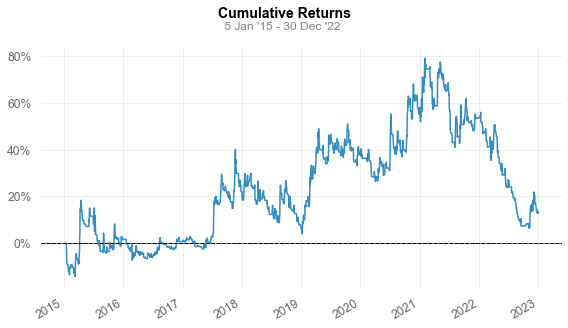

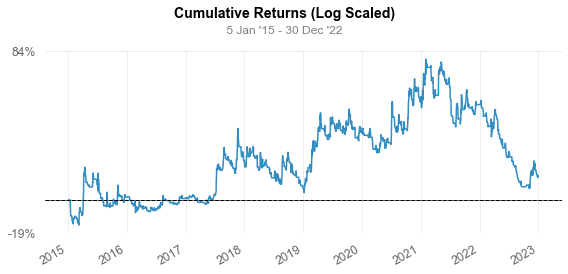

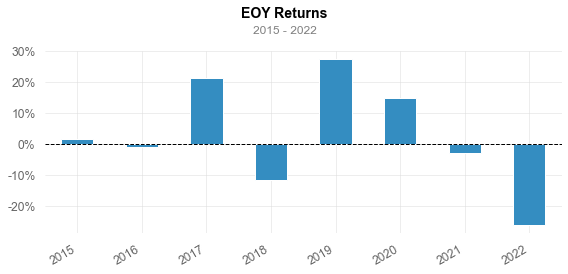

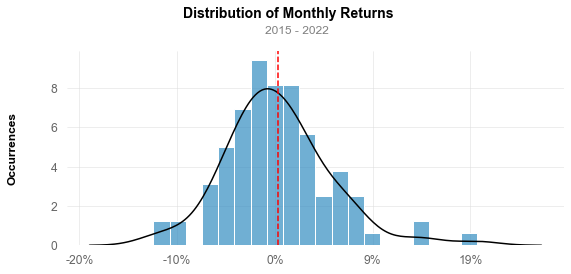

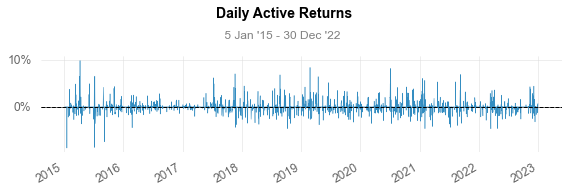

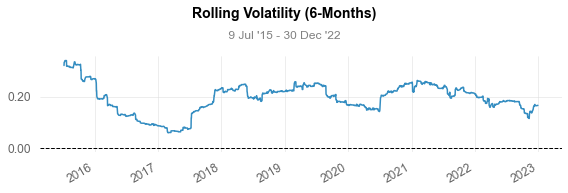

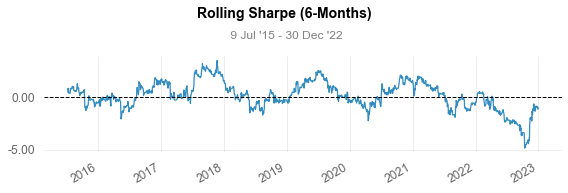

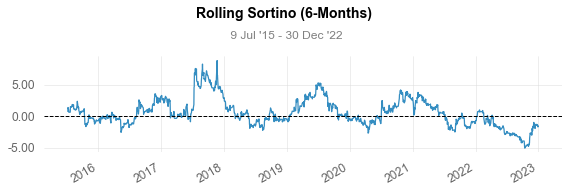

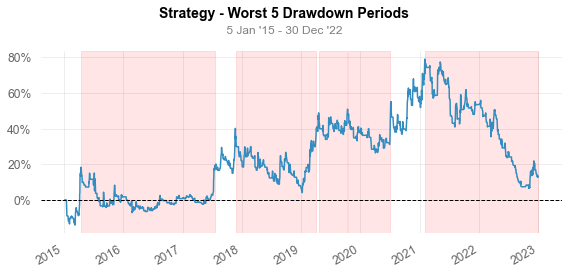

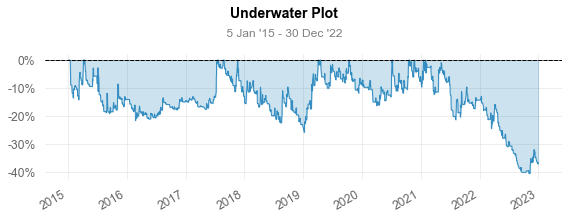

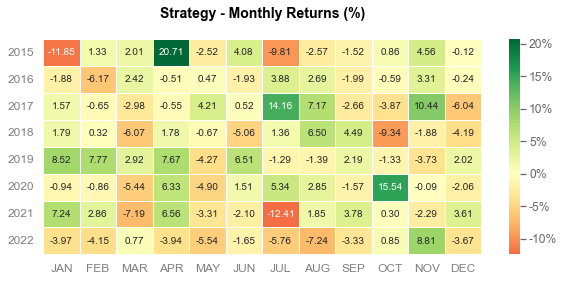

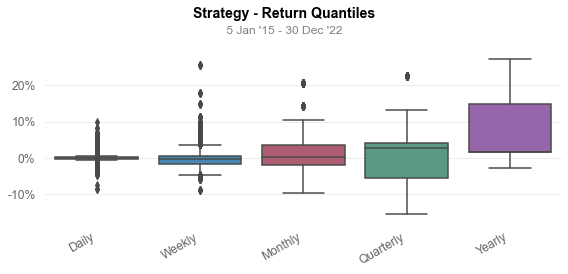

In [29]:
# 创建回测引擎对象
cerebro = bt.Cerebro()

stock_data = PandasData(
                dataname=stock_zh_a_hist_df,
                datetime=0,  # 日期列
                open=1,  # 开盘价所在列
                high=2,  # 最高价所在列
                low=3,  # 最低价所在列
                close=4,  # 收盘价所在列
                volume=5,
                fromdate=dt.strptime(start_date, '%Y%m%d'),  # 起始日  dt.strptime(start, '%Y%m%d')
                todate=dt.strptime(end_date, '%Y%m%d'),  # 结束日
            )
cerebro.adddata(stock_data, name='stock')

start_cash=1000000

cerebro.addstrategy(SmaCross)
# cerebro.addstrategy(SmaCross, period=10)
# 设置现金
cerebro.broker.setcash(start_cash)
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='PyFolio')
# 设置交易费用
comminfo = StockCommission(commission=0.0002, stamp_duty=0.001) # 实例化 
cerebro.broker.addcommissioninfo(comminfo)

print('初始市值: %.2f' % cerebro.broker.getvalue())
results = cerebro.run()
strat = results[0]

portfolio_stats = strat.analyzers.getbyname('PyFolio')
returns, _,_,_ = portfolio_stats.get_pf_items()

returns.index=returns.index.tz_convert(None)
print('最终市值: %.2f' % cerebro.broker.getvalue())
# logger.info(f'================================= 回测结束 {dt.now().strftime("%Y%m%d %H:%M:%S")} =========================================')
qs.reports.full(returns)